In [1]:
import optuna
import pandas as pd
import numfolio as nf
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from numfolio.stats import risk_adjusted_reward
from sklearn.model_selection import train_test_split

df = pd.read_excel('Data/fetch_etf.xlsx', sheet_name='clean')
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)
train, test = train_test_split(df, test_size=0.3, shuffle=False)

/tmp/ipykernel_102159/3364595814.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


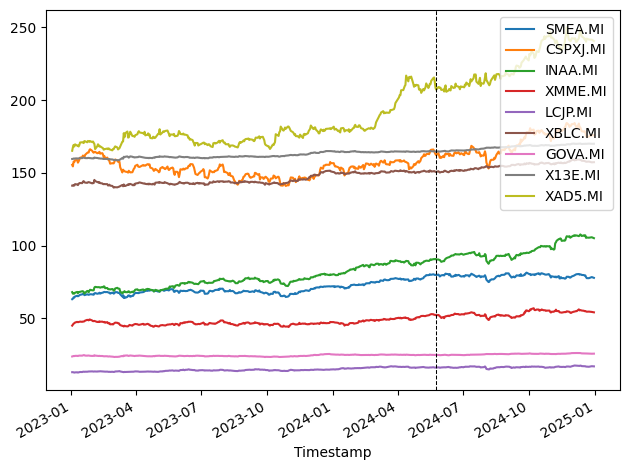

In [2]:
fig, ax = plt.subplots(1, 1)
df.plot(ax=ax)
ax.axvline(train.index[-1], linestyle='dashed', color='black', linewidth=0.75)
fig.tight_layout()
fig.show()

In [3]:
columns = df.columns

N_TRIALS = 1000
N_EXPERIMENTS = 3
# variables
budget = 10000
max_var = budget * 0.01
max_drawdown = max_var * 5
min_diversification = 3
min_r2 = 0.3

lp = train.iloc[-1]
r = train.diff()

max_weight = int(budget/lp.max())

guess = (lp*(r.mean().abs()/r.std())).clip(upper=max_weight).astype(int)

def make_potfolio_returns(data, weights) -> pd.DataFrame:

    return data.ffill().diff().dropna() @ [weights[c] for c in data.columns]

class Objective(object):

    def __init__(self, score, penalty: float = -1.):

        self.score = score
        self.penalty = penalty

    def __call__(self, trial):

        weights = dict()
        for col in columns:
            weights[col] = trial.suggest_int(col, 0, max_weight)
    
        returns = make_potfolio_returns(data=train, weights=weights)
        returns = returns.values
    
        b = sum([lp[k] * v for k, v in weights.items()])
        if b > budget:
            return self.penalty
        
        if len([v for v in weights.values() if v > 0]) < min_diversification:
            return self.penalty
    
        if nf.compute_var(returns) > max_var:
            return self.penalty
    
        if nf.compute_max_drawdown(returns) > max_drawdown:
            return self.penalty
    
        if nf.compute_stability_of_timeseries(returns) < min_r2:
            return self.penalty
                
        return self.score(returns=returns)

optuna.logging.set_verbosity(optuna.logging.WARNING)

records = list()
scores = [f.replace('compute_', '') for f in dir(risk_adjusted_reward) if f.endswith('ratio')]

#shuffle(scores)
    
for s in scores:
    print(f'\n>>> {s}')

    out = {'score': s}
    score = getattr(nf, f'compute_{s}')
    obj = Objective(score=score)
    study_name = f'study_{s}'
    
    study = optuna.create_study(study_name=study_name, direction='maximize', load_if_exists=True)

    # add initial guess point as well as other optimal points
    study.enqueue_trial(guess.to_dict())
    for r in records:
        study.enqueue_trial({k: v for k, v in r.items() if v in columns})
        
    # The optimization finishes after evaluating N_TRIALS times or 100 seconds.
    study.optimize(obj, n_trials=N_TRIALS, timeout=100, show_progress_bar=True)
    
    print(f"Best params for score {s} is {study.best_params} with value {study.best_value}")
    out['best_value'] = study.best_value
    out = {**out, **study.best_params}
    records.append(out)

records = pd.DataFrame(records)

guess['score'] = 'guess'
guess['best_value'] = 1.0

records = pd.concat([records, guess.to_frame().T])


>>> calmar_ratio


  0%|          | 0/1000 [00:00<?, ?it/s]

Best params for score calmar_ratio is {'SMEA.MI': 9, 'CSPXJ.MI': 0, 'INAA.MI': 14, 'XMME.MI': 2, 'LCJP.MI': 9, 'XBLC.MI': 3, 'GOVA.MI': 7, 'X13E.MI': 29, 'XAD5.MI': 8} with value 0.3223223204238145

>>> cvar_sharpe_ratio


  0%|          | 0/1000 [00:00<?, ?it/s]

Best params for score cvar_sharpe_ratio is {'SMEA.MI': 17, 'CSPXJ.MI': 0, 'INAA.MI': 27, 'XMME.MI': 1, 'LCJP.MI': 28, 'XBLC.MI': 5, 'GOVA.MI': 10, 'X13E.MI': 12, 'XAD5.MI': 11} with value 1.4231941337908613

>>> omega_ratio


  0%|          | 0/1000 [00:00<?, ?it/s]

Best params for score omega_ratio is {'SMEA.MI': 14, 'CSPXJ.MI': 0, 'INAA.MI': 18, 'XMME.MI': 3, 'LCJP.MI': 1, 'XBLC.MI': 4, 'GOVA.MI': 2, 'X13E.MI': 20, 'XAD5.MI': 8} with value 24.24054280115126

>>> sharpe_ratio


  0%|          | 0/1000 [00:00<?, ?it/s]

Best params for score sharpe_ratio is {'SMEA.MI': 33, 'CSPXJ.MI': 0, 'INAA.MI': 30, 'XMME.MI': 0, 'LCJP.MI': 5, 'XBLC.MI': 0, 'GOVA.MI': 11, 'X13E.MI': 5, 'XAD5.MI': 15} with value 2.6126692890810097

>>> sortino_ratio


  0%|          | 0/1000 [00:00<?, ?it/s]

Best params for score sortino_ratio is {'SMEA.MI': 5, 'CSPXJ.MI': 0, 'INAA.MI': 26, 'XMME.MI': 1, 'LCJP.MI': 4, 'XBLC.MI': 4, 'GOVA.MI': 0, 'X13E.MI': 28, 'XAD5.MI': 7} with value 4.666949307861559

>>> sterling_ratio


  0%|          | 0/1000 [00:00<?, ?it/s]

Best params for score sterling_ratio is {'SMEA.MI': 18, 'CSPXJ.MI': 0, 'INAA.MI': 21, 'XMME.MI': 0, 'LCJP.MI': 6, 'XBLC.MI': 0, 'GOVA.MI': 18, 'X13E.MI': 19, 'XAD5.MI': 9} with value 1.5021867652818832

>>> tail_ratio


  0%|          | 0/1000 [00:00<?, ?it/s]

Best params for score tail_ratio is {'SMEA.MI': 27, 'CSPXJ.MI': 0, 'INAA.MI': 1, 'XMME.MI': 10, 'LCJP.MI': 24, 'XBLC.MI': 26, 'GOVA.MI': 13, 'X13E.MI': 13, 'XAD5.MI': 2} with value 1.504483523737928

>>> var_sharpe_ratio


  0%|          | 0/1000 [00:00<?, ?it/s]

Best params for score var_sharpe_ratio is {'SMEA.MI': 13, 'CSPXJ.MI': 0, 'INAA.MI': 34, 'XMME.MI': 9, 'LCJP.MI': 5, 'XBLC.MI': 6, 'GOVA.MI': 25, 'X13E.MI': 0, 'XAD5.MI': 13} with value 1.7881526317699408


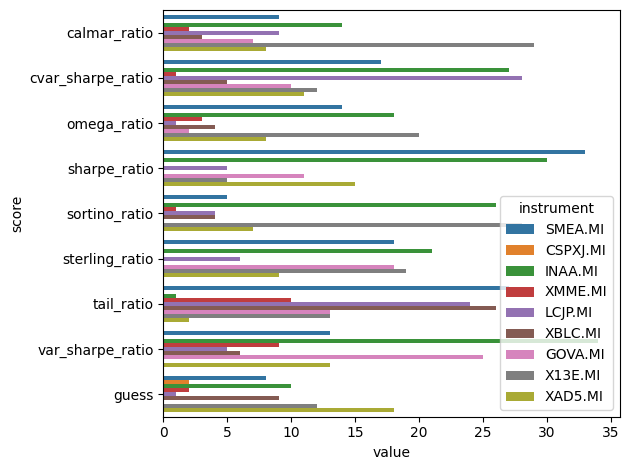

In [4]:
w = records.set_index('score')[columns].stack().reset_index().rename(columns={'level_1': 'instrument', 0: 'value'})
fig, ax = plt.subplots(1, 1)
sns.barplot(w, y='score', x='value', hue='instrument', ax=ax)
fig.tight_layout()

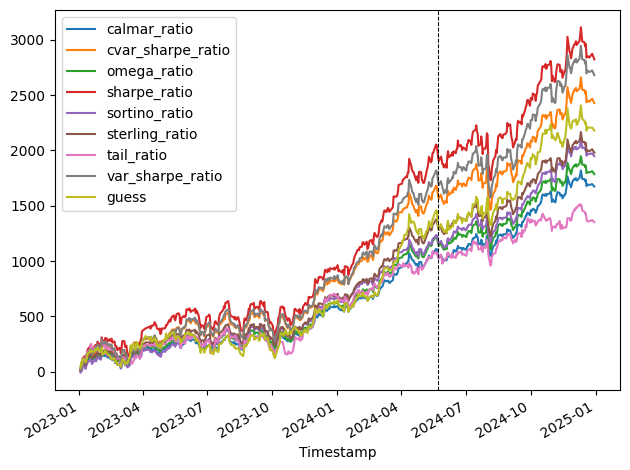

In [5]:
portfolios = list()
for idx, row in records.iterrows():
    best = row[columns].to_dict()
    best_ptf = make_potfolio_returns(data=df, weights=best)
    best_ptf.name = row['score']
    portfolios.append(best_ptf.cumsum())

portfolios = pd.concat(portfolios, axis='columns')

fig, ax = plt.subplots(1, 1)
portfolios.plot(ax=ax)
ax.axvline(train.index[-1], linestyle='dashed', color='black', linewidth=0.75)
fig.tight_layout()

In [6]:
ld = train.index[-1]
for col in portfolios.columns:

    print(f'\n>>> {col}')
    p = portfolios[[col]].rename(columns={col: 'pnl'})
    p_train, p_test = p.loc[:ld], p.loc[ld:]
    scorecard_train = nf.get_scorecard(p_train)['Total']
    scorecard_test = nf.get_scorecard(p_test)['Total']
    scorecard = pd.concat([scorecard_train, scorecard_test], axis='columns')
    scorecard.columns = ['Train', 'Test']
    print(scorecard)


>>> calmar_ratio
                    Train        Test
Sharpe-Ratio     2.479595    2.374244
Sortino-Ratio    4.488107    3.091771
MaxDD          145.092000  198.373000
VaR             25.844750   38.158000
CVaR            33.156799   62.919340
FinalP&L       993.617000  648.580000

>>> cvar_sharpe_ratio
                     Train        Test
Sharpe-Ratio      2.563338    1.907840
Sortino-Ratio     4.371393    2.372914
MaxDD           250.446000  413.612000
VaR              41.762200   57.538400
CVaR             50.222012  101.644697
FinalP&L       1537.516000  862.250000

>>> omega_ratio
                     Train        Test
Sharpe-Ratio      2.595430    2.100381
Sortino-Ratio     4.485537    2.664987
MaxDD           165.968000  253.762000
VaR              28.156900   40.176400
CVaR             35.621139   69.912585
FinalP&L       1107.978000  647.110000

>>> sharpe_ratio
                     Train        Test
Sharpe-Ratio      2.591776    1.647023
Sortino-Ratio     4.277781    2.06